## Hadamard Test

The Hadamard Test is a way to benchmark the fidelity of applying a quantum unitary. By measuring the probability of the output qubit in the $|0\rangle$ state, we can recover the real part of the expectation value of the unitary with the formula:

$$\text{Re}\left\{\langle 0 | \hat{U} | 0 \rangle \right\} = 2P_{|0\rangle}-1$$

In this case, we will measure the QFT unitary, $\hat{U}_\text{QFT}$. This unitary maps a quantum state $|x\rangle = \sum_k x_k|k\rangle$ to a quantum state $|y\rangle = \sum_k y_k|k\rangle$ according to the formula
$$y_k = \frac1{\sqrt{N}}\sum_{n=0}^{N-1}x_n \exp\left(2\pi i \cdot \frac{nk}{N}\right)$$
where $N$ is the number of basis states, which is $2^n$ for $n$ qubits. 

When performing the Hadamard transform on this unitary, we only measure $\langle 0 |\hat{U}_\text{QFT}|x\rangle=y_0$, and $|x\rangle=|0\rangle$, which is
$$\begin{aligned}y_0 &= \frac1{\sqrt{N}}\sum_{n=0}^{N-1}x_n \exp\left(2\pi i \cdot \frac{n*0}{N}\right) \\
&= \frac1{\sqrt{N}} x_0 \cdot 1 \\
&= N^{-1/2}
\end{aligned}$$
and is always real. 

In [35]:
from classiq import (
    qfunc, Output, QBit, QArray, QCallable,
    allocate, within_apply, control,
    set_constraints, Constraints, set_execution_preferences, QuantumProgram,
    create_model, synthesize, execute, write_qmod,
    H, qft,
)
from classiq.execution import ExecutionPreferences

In [36]:
"""
qfunc main(output expectation_value: qbit) {
    allocate<1>(expectation_value);
    psi: qbit[];
    allocate<4>(psi);

    within {
        H(expectation_value);
    } apply {
        control(expectation_value){
            qft(psi);
        }
    }
}
"""
@qfunc
def main(res: Output[QBit]):
    allocate(1, res)
    psi = QArray('psi')
    allocate(4, psi)
    within_apply(
        lambda: H(res),
        lambda: control(res, lambda: qft(psi))
    )


In [37]:
qmod = create_model(main)
write_qmod(qmod, "hadamard_transform.qmod")
#depth = set_constraints(
#    qmod, Constraints(optimization_parameter="depth")
#)
allcounts = []
numshots = [1000,2000,4000,8000,16000,32000]
for nshots in numshots:
    execution_model = set_execution_preferences(
        qmod,
        ExecutionPreferences(
            num_shots=nshots, job_name=f"hadamard_transform_{nshots}", random_seed=767
        ),
    )
    qprog = synthesize(execution_model)
    #circuit_width = QuantumProgram.from_qprog(qprog).data.width
    #circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    #print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
    job = execute(qprog)
    print(
        f"Job with {job.num_shots} shots is {job.status} on provider-backend={job.provider}-{job.backend_name} and can be accessed at {job.ide_url}"
    )
    # view job in web
    #job.open_in_ide()
    results = job.result()[0].value
    counts = results.counts
    allcounts.append((counts['0'], counts['1']))
    #counts_dict = results.parsed_counts
    #states = results.parsed_states
    #lsb_left_or_right = results.counts_lsb_right

Job with 1000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/d0edca89-6419-4c02-97f5-2910ddebd423
Job with 2000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/d02d2269-918a-4a08-89ad-70fd28b46bee
Job with 4000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/08d18150-1e38-47e2-8890-3f02b7b0c855
Job with 8000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/c5ce3116-91ce-4cfa-9969-0aad137b23ab
Job with 16000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/a9d04e1c-3e5d-46ac-aad3-2338b82636ed
Job with 32000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/300d68f5-4190-449f-b659-7d8aa195836d


In this case, we perform QFT on an array of 4 qubits, so we have $N=2^4$ basis states, meaning $y_0=(2^4)^{-1/2}=\frac14$. We can equate this with the measured ground state probability as $y_0 = 2P_0 - 1 \to \frac{y_0 + 1}{2} = P_0$, which means the expected ground state probability is $5/8=0.625$

[0.602      0.61       0.61275    0.619875   0.62225    0.62203125]


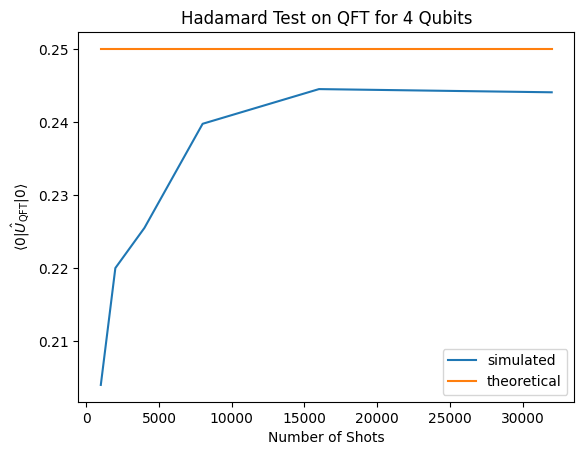

In [41]:
import numpy as np
import matplotlib.pyplot as plt

th_probs = 3/4*np.ones(len(numshots))

counts = np.array(allcounts)
probabilities = counts[:,0]/np.sum(counts, axis=1)
print(probabilities)

fix, ax = plt.subplots()
ax.plot(numshots, 2*probabilities-1, label='simulated')
ax.plot(numshots, 1/4*np.ones_like(numshots), label='theoretical')
plt.legend()
plt.title('Hadamard Test on QFT for 4 Qubits')
plt.ylabel(r'$\langle 0| \hat{U}_\text{QFT} | 0 \rangle$')
plt.xlabel('Number of Shots')
plt.show()
# Re{ <0| U_{QFT} |0> } = 2 P_0 - 1